### Preparing data for visualization

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from datetime import *

# load data and extract relevant features
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
weather_data = pd.read_csv("processed_weather_data.csv", dtype={'Time':str})

# converts 12 hour time to 24 hourtime
def convert_to_24h_time(time):
    return datetime.strftime(datetime.strptime(time, '%I:%M %p'), "%H:%M")


# converts month to its numeric representation
def convert_to_numeric_month(months):
    numeric_month = months.map({'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,
                                'July':7,'August':8,'September':9,'October':10,'November':11,'December':12})
    return numeric_month


# extracts hour of departure from timestamps
def extract_departure_hour(times):
    times = times.str.replace(':', '').astype(int)
    hours = times.astype(str).str[:-2]
    return hours


# assins each departure region a region code 
def map_departure_harbors(trips):
    departure_map = {'Tsawwassen to Swartz Bay':3, 'Tsawwassen to Southern Gulf Islands':3,'Tsawwassen to Duke Point':3,
                     'Departure Bay to Horseshoe Bay':2, 'Duke Point to Tsawwassen':2,
                     'Swartz Bay to Fulford Harbour (Saltspring Is.)':4, 'Swartz Bay to Southern Gulf Islands':4, 'Swartz Bay to Tsawwassen':4, 
                     'Horseshoe Bay to Snug Cove (Bowen Is.)':1,'Horseshoe Bay to Departure Bay':1, 'Horseshoe Bay to Langdale':1,'Langdale to Horseshoe Bay':1}
    return trips.map(departure_map)


# adds indicators for holiday weekends
def add_holidays(dates):
    holiday_weekends = ['25 March 2016','26 March 2016','27 March 2016','28 March 2016', 
                        '14 April 2017','15 April 2017','16 April 2017','17 April 2017', #easter
                        '30 March 2018','31 March 2018','1 April 2018','2 April 2018',
                        '20 May 2016','21 May 2016','22 May 2016', '23 May 2016',
                        '19 May 2017','20 May 2017','21 May 2017', '22 May 2017', #victoria day
                        '18 May 2018','19 May 2018','20 May 2018',  '21 May 2018',
                        '30 June 2016','01 July 2016','02 July 2016', '03 July 2016', #bcday
                        '30 June 2017','01 July 2017','02 July 2017', '03 July 2017',
                        '29 June 2018','30 June 2018','01 July 2018','02 July 2018',
                        '02 September 2016', '03 September 2016','04 September 2016','05 September 2016', #labor data
                        '01 September 2017','02 September 2017','03 September 2017', '04 September 2017',
                        '23 December 2016','24 December 2016','26 December 2016','27 December 2016', #christmas
                        '22 December 2017','23 December 2017','24 December 2017','26 December 2017',
                        '21 December  2018','22 December 2018','23 December 2018','26 December 2018',
                        '29 December 2016','30 December 2016','31 December 2016', '01 January 2017', # new years
                        '28 December 2017','29 December 2017','30 December 2017','31 December 2017','01 January 2018'] 
    holidays = dates.isin(holiday_weekends)
    return holidays


# adds known weather events (i.e. high winds)
def add_weather_events(dates):
    weather_events = severe_weather_dates = ['04 December 2016','05 December 2016','24 November 2016', 
                                             '14 October 2016', '13 November 2017', '20 December 2018', '19 November 2017', 
                                             '14 November 2017', '15 November 2017', '07 April 2017', '21 January 2018', '21 January 2018', '28 February 2018']
    severe_weather = dates.isin(weather_events)
    return severe_weather


# adds average windspeed of the day
def add_daily_avg_windspeed(data):
    avg_windspeeds = data.groupby('Full.Date')['Wind.Speed.km.per.h'].mean().to_dict()
    data['avg.Wind'] = data['Full.Date'].map(avg_windspeeds)
    return data


# assigns a float [0, 1] to the day indicating the 'niceness' of the day
def create_weather_score_data():
    data = pd.read_csv("victoria.csv")
    data.loc[data['Weather'].isin(['Clear', 'Mainly Clear']), 'Weather.Score'] = 1
    data.loc[~data['Weather'].isin(['Clear', 'Mainly Clear']) & ~(data['Weather'].isnull()), 'Weather.Score'] = 0 
    weather_score_data = data.groupby(['Year', 'Month', 'Day'], as_index=False)['Weather.Score'].mean()
    return weather_score_data


# gets ratio of number of sailings on a particular day to average daily sailings (grouped by month)
def add_num_sailings_ratio(data):
    avgs = data.groupby(['Year','Month'], as_index=False)['Trip'].count()

    avgs['Trip'] = avgs['Trip']/data.groupby(['Year','Month'], as_index=False)['Day.of.Month'].nunique()
    tripCounts = pd.merge(data, avgs.rename(columns={'Trip':'avg.Trips'}), how='left', on=['Year', 'Month'])
    tripCounts_with_date = pd.merge(tripCounts, data.groupby('Full.Date', as_index=False)['Trip'].count().rename(columns={'Trip':'num.Trips'}), how='left', on='Full.Date')
    
    tripCounts_with_date['Sailings.Ratio'] = tripCounts_with_date['num.Trips']/tripCounts_with_date['avg.Trips']
    return tripCounts_with_date.drop(columns=['avg.Trips', 'num.Trips'])
    
    
def process_data(data, weather_data):
    # prepare data for merging
    data['Scheduled.Departure'] = data['Scheduled.Departure'].apply(convert_to_24h_time)
    data['Departure.Hour'] = extract_departure_hour(data['Scheduled.Departure'])
    data['Scheduled.Departure'] = data['Scheduled.Departure'].astype(str).str.replace(':', '').astype(int)
    data['Region.Code'] = map_departure_harbors(data['Trip'])
    data['Month'] = convert_to_numeric_month(data['Month'])
    
    # prepare weather data and weather score data
    weather_data['Time.Hour'] = extract_departure_hour(weather_data['Time'])
    weather_score_data = create_weather_score_data()
    
    # add weather data
    data = pd.merge(data, weather_data, how='left', 
                    left_on=['Year', 'Month', 'Day.of.Month', 'Departure.Hour', 'Region.Code'], 
                    right_on=['Year', 'Month', 'Day.of.Month', 'Time.Hour', 'Region.Code'])
    
    # drop duplicated columns and rename columns the were name changed during the pd.merge
    data = data.rename(columns={'Full.Date_x':'Full.Date', 'Day_x':'Day'})
    data = data.drop(columns=['Full.Date_y','Region.Code', 'Day_y'])
    
    # add engineered features
    data['is.Holiday'] = add_holidays(data['Full.Date'])
    data['Severe.Weather'] = add_weather_events(data['Full.Date'])
    data = add_daily_avg_windspeed(data)
    data = add_num_sailings_ratio(data)

    
    # add weather score data
    data = pd.merge(data, weather_score_data, how='left',
                    left_on=['Year', 'Month', 'Day.of.Month'], 
                    right_on=['Year', 'Month', 'Day'])
    
    data = data.drop(columns=['Time.Hour'])
    data = data.rename(columns={'Day_x':'Day'})
    data = data.drop(columns=['Day_y'])
    return data


train_data = process_data(train_data, weather_data)
test_data = process_data(test_data, weather_data)


def verify_data_length(train_data, test_data):
    assert(len(train_data)==49504)
    assert(len(test_data)==12376)
    print("All observations present")

verify_data_length(train_data, test_data)
    
train_data.to_csv("processed_train.csv", index=False)
test_data.to_csv("processed_test.csv", index=False)

All observations present


### Preparing data for modelling

In [2]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
import random

train_data = train_data[['Vessel.Name', 'Scheduled.Departure', 'Trip', 'Day', 'Wind.Speed.km.per.h', 'is.Holiday', 'Severe.Weather', 'avg.Wind',
                         'Sailings.Ratio', 'Weather.Score', 'Month', 'Year', 'Day.of.Month', 'Time', 'Full.Date', 'Delay.Indicator']]
test_data = test_data[['Vessel.Name', 'Scheduled.Departure', 'Trip', 'Day', 'Wind.Speed.km.per.h', 'is.Holiday', 'Severe.Weather', 'avg.Wind',
                       'Sailings.Ratio', 'Weather.Score', 'Month', 'Year', 'Day.of.Month', 'Time', 'Full.Date',]]


train_data['Summer.Season'] = (train_data['Month'].isin([6,7,8]))
test_data['Summer.Season'] = (test_data['Month'].isin([6,7,8]))

train_data['off.Season'] = (train_data['Month'].isin([1, 2]))
test_data['off.Season'] = (test_data['Month'].isin([1, 2]))


def fill_windspeed(data):
    data['Wind.Speed.km.per.h'] = data['Wind.Speed.km.per.h'].fillna(10)
    return data

train_data = fill_windspeed(train_data)
test_data = fill_windspeed(test_data)


# randomly select 11 days to be used in the validation set
arr=list(range(1, 30))
random.seed(0)
random.shuffle(arr)
rand_days = arr[0:10]
    
# select the sailing on the randomly selected days to be used in the validation set
# only selecting from months that exist in the testing data {December, January, February, March}
val_data = train_data[(((train_data['Month'].isin([1, 2, 3])) & (train_data['Year']==2017)) | (train_data['Month'].isin([12])) & (train_data['Year']==2016)) & (train_data['Day.of.Month'].isin(rand_days))]

train_data = train_data[~((((train_data['Month'].isin([1, 2, 3])) & (train_data['Year']==2017)) | (train_data['Month'].isin([12])) & (train_data['Year']==2016)) & (train_data['Day.of.Month'].isin(rand_days)))]


# drop non-modelling features
def drop_features(data):
    data = data.drop(columns = ['Full.Date', 'Time', 'Day.of.Month', 'Year', 'Month'])
    return data

train_data = drop_features(train_data)
val_data = drop_features(val_data)
test_data = drop_features(test_data)

print(train_data.dtypes)
print('\n\n')
print(len(train_data.columns))

categorical_features = ['Vessel.Name', 'Day', 'Trip']\

train_data = pd.get_dummies(train_data, columns=categorical_features)
val_data = pd.get_dummies(val_data, columns=categorical_features)
test_data = pd.get_dummies(test_data, columns=categorical_features)

# if a column is not present in validation/testing data models will throw an error
# adds columns from the training data that are not present in testing data
def add_missing_columns(donor_data, data):
    missing_cols = set(donor_data.columns ) - set( data.columns )
    # Add a missing column in test set with default value equal to 0
    for c in missing_cols:
        data[c] = 0
    # Ensure the order of column in the test set is in the same order than in train set
    data = data[donor_data.columns]
    return data

val_data = add_missing_columns(train_data, val_data)
test_data = add_missing_columns(train_data, test_data).drop(columns=['Delay.Indicator'])

y = train_data['Delay.Indicator'].astype(bool)
X = train_data.drop(columns=['Delay.Indicator'])

X_val = val_data.drop(columns=['Delay.Indicator'])

Vessel.Name             object
Scheduled.Departure      int32
Trip                    object
Day                     object
Wind.Speed.km.per.h    float64
is.Holiday                bool
Severe.Weather            bool
avg.Wind               float64
Sailings.Ratio         float64
Weather.Score          float64
Delay.Indicator          int64
Summer.Season             bool
off.Season                bool
dtype: object



13


#### Random Forest Training

In [3]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=500, max_depth=15, 
                             random_state=1, n_jobs=-1)
rfc.fit(X,y)
res_rfc = rfc.predict_proba(X_val)

y_val = val_data[['Delay.Indicator']].astype(bool)
roc_auc_score(y_val['Delay.Indicator'], res_rfc[:,1])

0.8107808119214964

Text(0.5, 1.0, 'Feature Importance (Random Forest, top 15)')

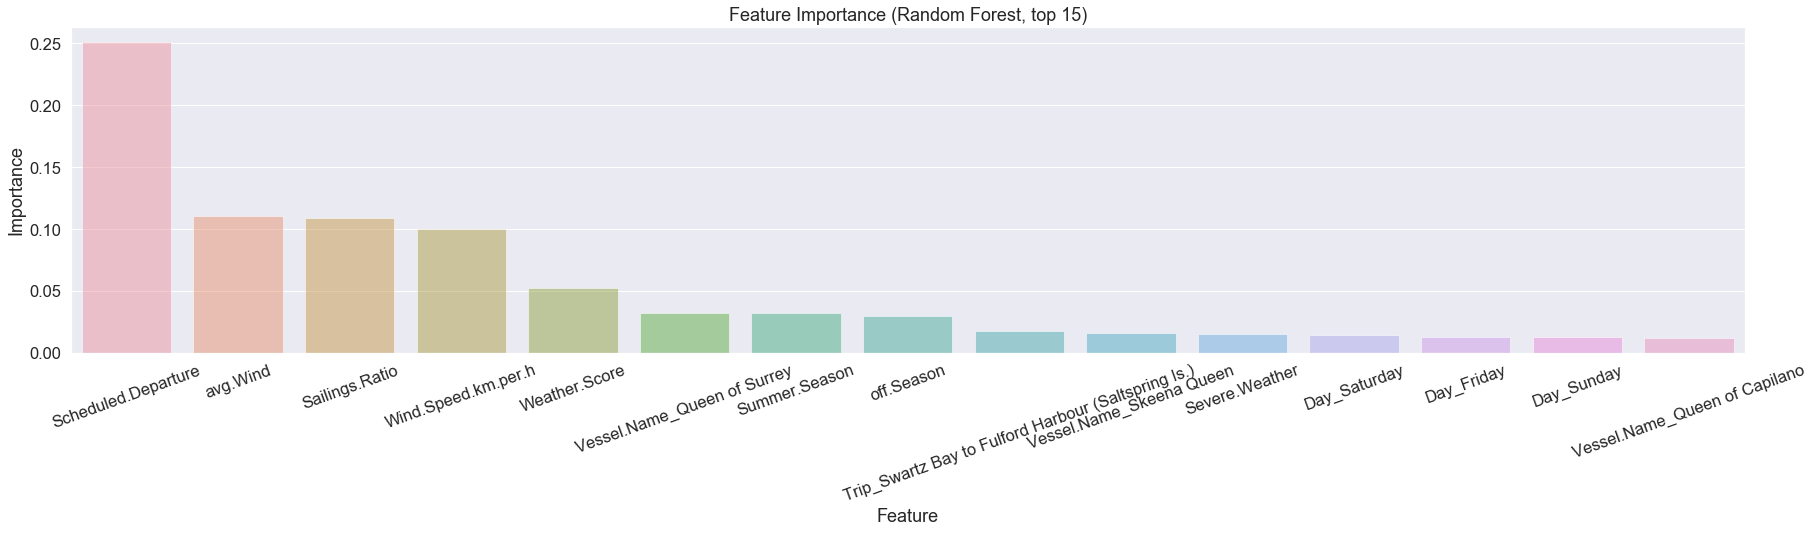

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
sns.set(font_scale=1.5)

featureImportance = pd.concat((pd.DataFrame(X.columns, columns = ['Feature']), 
           pd.DataFrame(rfc.feature_importances_, columns = ['Importance'])), 
          axis = 1).sort_values(by='Importance', ascending = False)[:15]
plt.subplots(figsize=(30,6))
g = sns.barplot(x=featureImportance['Feature'], y=featureImportance['Importance'], alpha=.5)
g.set_xticklabels(g.get_xticklabels(),rotation=20)#.set_title('Feature Importance')
g.set_title('Feature Importance (Random Forest, top 15)')

#### Logistic Regression Training

In [5]:
from sklearn.linear_model import LogisticRegression
lc = LogisticRegression(penalty='l2')
lc.fit(X,y)
res_lc = lc.predict_proba(X_val)

y_val = val_data[['Delay.Indicator']].astype(bool)
roc_auc_score(y_val['Delay.Indicator'], res_lc[:,1])

c:\users\matth\pycharmprojects\imageclassification\venv\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.709637384162099

#### XGBoost Training

In [6]:
import xgboost as xgb
dtrain = xgb.DMatrix(X, label=y)
dval = xgb.DMatrix(X_val, label=val_data['Delay.Indicator'])

param = {'max_depth':5, 'eta': .1, 'objective': 'binary:logistic', 'eval_metric':'auc'}
evals = [(dval, 'eval')]

bst = xgb.train(param, dtrain, 1000, evals=evals, early_stopping_rounds=20)

dtest = xgb.DMatrix(test_data)

c:\users\matth\pycharmprojects\imageclassification\venv\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\matth\pycharmprojects\imageclassification\venv\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	eval-auc:0.652711
Will train until eval-auc hasn't improved in 20 rounds.
[1]	eval-auc:0.652483
[2]	eval-auc:0.708263
[3]	eval-auc:0.724076
[4]	eval-auc:0.725145
[5]	eval-auc:0.757789
[6]	eval-auc:0.760786
[7]	eval-auc:0.762879
[8]	eval-auc:0.765149
[9]	eval-auc:0.764351
[10]	eval-auc:0.765201
[11]	eval-auc:0.764441
[12]	eval-auc:0.76762
[13]	eval-auc:0.769978
[14]	eval-auc:0.771988
[15]	eval-auc:0.773967
[16]	eval-auc:0.776398
[17]	eval-auc:0.777738
[18]	eval-auc:0.779231
[19]	eval-auc:0.781459
[20]	eval-auc:0.782528
[21]	eval-auc:0.784916
[22]	eval-auc:0.786016
[23]	eval-auc:0.786336
[24]	eval-auc:0.787542
[25]	eval-auc:0.788513
[26]	eval-auc:0.789914
[27]	eval-auc:0.790673
[28]	eval-auc:0.792288
[29]	eval-auc:0.792756
[30]	eval-auc:0.793293
[31]	eval-auc:0.794305
[32]	eval-auc:0.795622
[33]	eval-auc:0.796122
[34]	eval-auc:0.795913
[35]	eval-auc:0.797019
[36]	eval-auc:0.796665
[37]	eval-auc:0.797244
[38]	eval-auc:0.800018
[39]	eval-auc:0.799023
[40]	eval-auc:0.799196
[41]	eval-au

In [7]:
# feature importance for XGBoost
pd.DataFrame(bst.get_fscore().items(), columns=['feature','importance']).sort_values('importance', ascending=False).head(10)

,feature,importance
0,Scheduled.Departure,561
7,Sailings.Ratio,492
2,avg.Wind,461
1,Wind.Speed.km.per.h,213
23,Weather.Score,174
4,Vessel.Name_Queen of Capilano,145
12,Summer.Season,104
14,Day_Sunday,69
10,Vessel.Name_Queen of Surrey,66
9,Day_Saturday,64


### Test Set Predictions

In [8]:
res_rf = rfc.predict_proba(test_data)[:,1]

res_lc = lc.predict_proba(test_data)[:,1]

res_xg = bst.predict(dtest)

In [10]:
test_data = pd.read_csv("processed_test.csv")
submission = test_data[['ID']]
submission['Delay.Indicator_rf'] = res_rf
submission['Delay.Indicator_lc'] = res_lc
submission['Delay.Indicator_xg'] = res_xg

# ensemble
submission['Delay.Indicator'] = (submission['Delay.Indicator_xg']*.4 + submission['Delay.Indicator_rf']*.4  + submission['Delay.Indicator_lc']*.2)

print(submission.head(15))
submission[['ID', 'Delay.Indicator']].to_csv("ferry_submission.csv", index=False)

    ID  Delay.Indicator_rf  Delay.Indicator_lc  Delay.Indicator_xg  \
0    1            0.105420            0.088490            0.091171   
1    2            0.056063            0.074585            0.020322   
2    3            0.147840            0.143914            0.128189   
3    4            0.111564            0.120931            0.075009   
4    5            0.155333            0.227146            0.161069   
5    6            0.147275            0.197659            0.087341   
6    7            0.165935            0.349179            0.170618   
7    8            0.142769            0.302053            0.052166   
8    9            0.038888            0.136513            0.022860   
9   10            0.108793            0.182754            0.050669   
10  11            0.176893            0.196216            0.163054   
11  12            0.472581            0.258505            0.459001   
12  13            0.196280            0.292267            0.205260   
13  14            0.

c:\users\matth\pycharmprojects\imageclassification\venv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\matth\pycharmprojects\imageclassification\venv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
c:\users\matth\pycharmprojects\imageclassification\venv\lib\site-packages\ipykernel_launcher.py:5: Setting